In [18]:
from google.cloud import bigquery
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [19]:
master_table = "unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo"

def get_bigquery_data(query) -> pd.DataFrame:
    client = bigquery.Client() 
    query_job = client.query(query)
    return query_job.to_dataframe()

In [20]:
query = f"""
    SELECT fecha, sum(dolares) as dolares
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    where nivel_taric = '1' AND cod_taric = '87' AND tipo_movimiento_cod = 'I'
    group by fecha
"""

df = get_bigquery_data(query)

Epoch 1/50


c:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.8414e-04 - mae: 0.0194 - val_loss: 0.0530 - val_mae: 0.0870
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0537 - val_mae: 0.0847
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9575e-04 - mae: 0.0197 - val_loss: 0.0531 - val_mae: 0.0864
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.3144e-04 - mae: 0.0204 - val_loss: 0.0533 - val_mae: 0.0859
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9292e-04 - mae: 0.0200 - val_loss: 0.0533 - val_mae: 0.0859
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0529 - val_mae: 0.0874
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7596e-04 - mae: 0.0195 - val_loss: 0.0532 - val_mae: 0.0866
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3879e-04 - mae: 0.0179 - val_loss: 0.0529 - val_mae: 0.0877
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8400e-04

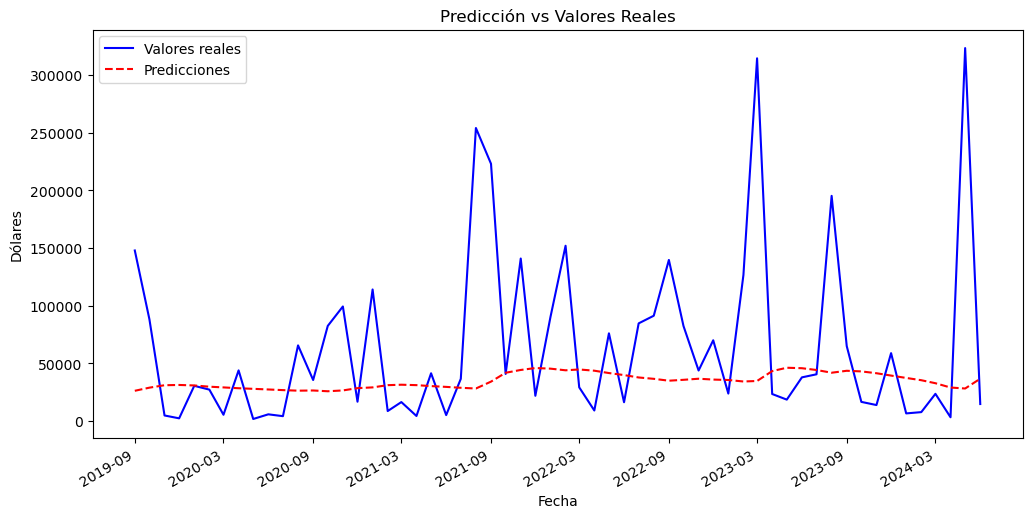

In [21]:
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')

data = df['dolares'].values

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(data_scaled, time_steps)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential([
    LSTM(256, activation='relu', input_shape=(time_steps, X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}, MAE: {mae}")

last_sequence = X_test[-1]
last_sequence = np.expand_dims(last_sequence, axis=0)
prediccion_escalada = model.predict(last_sequence)
prediccion_original = scaler.inverse_transform(prediccion_escalada)
print(f"Predicción para el siguiente valor: {prediccion_original[0, 0]}")


y_pred = model.predict(X_test)

import matplotlib.dates as mdates

y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 2)))))[:, 0]
y_pred_original = scaler.inverse_transform(np.hstack((y_pred, np.zeros((len(y_pred), 2)))))[:, 0]

fechas_test = df['fecha'].iloc[-len(y_test):]


plt.figure(figsize=(12, 6))
plt.plot(fechas_test, y_test_original, label="Valores reales", color="blue")
plt.plot(fechas_test, y_pred_original, label="Predicciones", color="red", linestyle="dashed")
plt.title("Predicción vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Dólares")
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()
plt.show()
